THE FOLLOWING STEPS ARE INVOLVED IN THE ENTIRE PROCESS OF IMAGE CLASSIFICATION

1.IMPORTING LIBRARIES

2.IMAGE PROCESSING

3.MODEL CREATION

4.MODEL COMPILATION

5.MODEL TRAINING

6.MODEL EVALUATION

7.MODEL PREDICTION

STEP 1-importing essential libraries
tensorflow is a deep learning framework suitable for applications involving neural networks.

using tensorflow we can build,train,evaluate and predict our neural network.

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

# loading the dataset
The training, testing and validation datasets are taken from the given dataset.

In [36]:
train_set='../input/curated-colon-dataset-for-deep-learning/train'
val_set='../input/curated-colon-dataset-for-deep-learning/val'
test_set='../input/curated-colon-dataset-for-deep-learning/test'

# STEP 2-image processing
the imagedatagenerator is used to implement data augmentation. we can process the image as we want and create batches of image data.

check this link for further details:- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [37]:
train_datagen = image.ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen = image.ImageDataGenerator()
test_datagen = image.ImageDataGenerator()

The images in digital world have pixels whose intensities range from 0 to 255 where black being 0 and white being 255.The rescaling of 1./255 allows it to convert to decimals values ranging from 0 to 1.

the flow_from_directory allow us to use the images availabe in the google colab files section. the dataset contains images of variable size. hence it is essential to reshape them to (224,224). (the input dimensions for pretrained model)

the batch size is an important parameter which can affect the training time and accuracy. less batch size increases accuracy and training time and vice versa. the batch size is taken as powers of two.

In [38]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    val_set,
    target_size=(224, 224),
    batch_size=16,
    shuffle=True,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)


Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [39]:
train_generator.class_indices

{'0_normal': 0, '1_ulcerative_colitis': 1, '2_polyps': 2, '3_esophagitis': 3}

# STEP 3-model creation
we are using the pretrained cnn meaning that the cnn is already trained on the imagenet dataset and has the weights stored in it. we are going to customise the model by adding additional layers of our choice(remember more layers can increase parameters leading to overfitting).

we are using the MobileNetV2 model for this application. this model was developed by google in 2017 and is known for its light memory. this model is ideal for devices with less RAM and processing power like microcomputers and mobiles.

input_shape=(224,224,3) => this is the input dimensions of the model. this is the parameter mentioned in the processing part. the 3 refers to the three channels R,G,B

we are training it partially so as to reduce the traning time on the stake of accuracy. (it is better to train model fully for better results)

> **NOTE- turn on the internet in the settings option in order to download the base model**

In [40]:
from keras.layers import Layer
from keras.utils.generic_utils import get_custom_objects

class CustomMaskLayer(Layer):
    def __init__(self, **kwargs):
        super(CustomMaskLayer, self).__init__(**kwargs)
        
    def call(self, inputs, mask=None):
        # Define the layer's behavior
        return inputs
    
    def compute_mask(self, inputs, mask=None):
        # Define the mask computation
        return mask
    
    def get_config(self):
        config = super(CustomMaskLayer, self).get_config()
        # Add any additional configuration settings
        return config

# Register the custom layer
get_custom_objects().update({'CustomMaskLayer': CustomMaskLayer})


In [41]:
base_model = tf.keras.applications.ResNet101(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(CustomGaussianNoise(0.35))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(CustomGaussianNoise(0.35))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
custom_gaussian_noise_4 (Cus (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
custom_gaussian_noise_5 (Cus (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

# Model Compilation
The built neural network has to be compiled before training. It is compiled using a loss function, optimizer and metrics. Here, crossentropy loss function, adam optimizer and accuracy, precision, recall and AUC are the different metrics.

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

** Callbacks**

In [43]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Model Training



TIP- ensure that the gpu (Graphics Processing Unit) is used so as to boost the training speed.

In [44]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


Epoch 1/20
200/200 [==============================] - 124s 581ms/step - loss: 4.9674 - accuracy: 0.7659 - precision: 0.7937 - recall: 0.7406 - auc: 0.9362 - val_loss: 4.4146 - val_accuracy: 0.8760 - val_precision: 0.8982 - val_recall: 0.8600 - val_auc: 0.9816
Epoch 2/20
200/200 [==============================] - 115s 574ms/step - loss: 4.1227 - accuracy: 0.9069 - precision: 0.9142 - recall: 0.8991 - auc: 0.9869 - val_loss: 3.9453 - val_accuracy: 0.8790 - val_precision: 0.8916 - val_recall: 0.8680 - val_auc: 0.9835
Epoch 3/20
200/200 [==============================] - 115s 574ms/step - loss: 3.6144 - accuracy: 0.9362 - precision: 0.9391 - recall: 0.9297 - auc: 0.9916 - val_loss: 3.5637 - val_accuracy: 0.8690 - val_precision: 0.8830 - val_recall: 0.8605 - val_auc: 0.9806
Epoch 4/20
200/200 [==============================] - 128s 642ms/step - loss: 3.2042 - accuracy: 0.9450 - precision: 0.9493 - recall: 0.9413 - auc: 0.9936 - val_loss: 3.1957 - val_accuracy: 0.8665 - val_precision: 0.8754

# Model evaluation
the trained model is evaluated on training, validation and test dataset

In [45]:
train_evaluation = model.evaluate(train_generator)

200/200 [==============================] - 83s 412ms/step - loss: 0.5606 - accuracy: 0.9900 - precision: 0.9903 - recall: 0.9894 - auc: 0.9998


In [46]:
val_evaluation = model.evaluate(validation_generator)

125/125 [==============================] - 31s 248ms/step - loss: 0.7905 - accuracy: 0.8935 - precision: 0.8973 - recall: 0.8910 - auc: 0.9886


In [47]:
test_evaluation = model.evaluate(test_generator)

50/50 [==============================] - 13s 267ms/step - loss: 0.7796 - accuracy: 0.9038 - precision: 0.9058 - recall: 0.9013 - auc: 0.9901


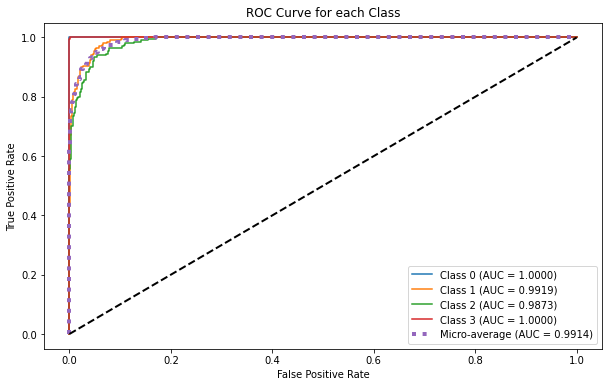

In [48]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Obtain the true labels and predicted probabilities from the test generator
test_steps = test_generator.samples // test_generator.batch_size
y_test = []
y_score = []

for i in range(test_steps):
    x_batch, y_batch = next(test_generator)
    y_test.append(y_batch)
    y_score.append(model.predict(x_batch))

# Convert lists to arrays
y_test = np.concatenate(y_test)
y_score = np.concatenate(y_score)

# Convert labels to binary matrix
y_test_bin = label_binarize(y_test, classes=range(test_generator.num_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves with class names
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.4f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each Class')
plt.legend(loc='lower right')

plt.show()


# Performance Plots
the plots for the different classification metrics are plotted here

 **Learning curve**

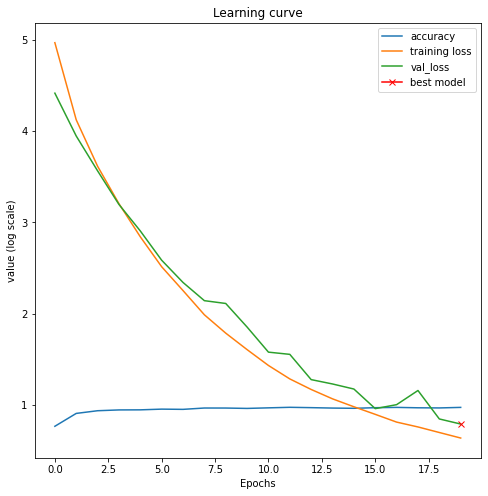

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend()

**Precision plot**

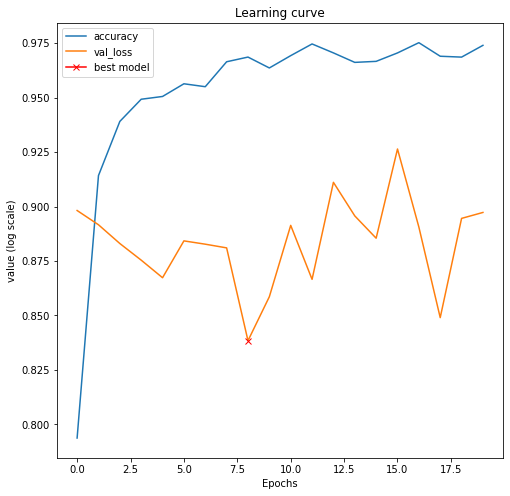

In [50]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["precision"], label="accuracy")
plt.plot(history.history["val_precision"], label="val_loss")
plt.plot( np.argmin(history.history["val_precision"]), np.min(history.history["val_precision"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

**Recall plot**

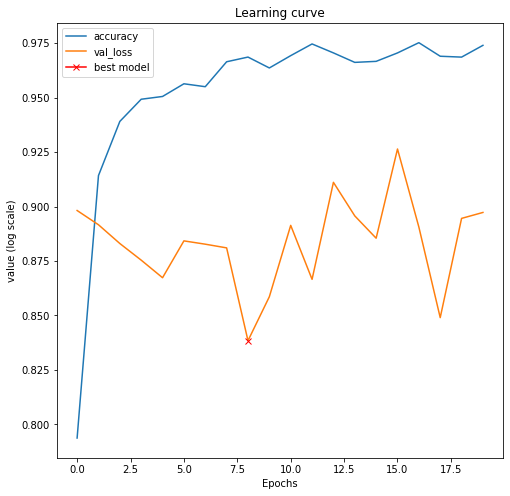

In [51]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["precision"], label="accuracy")
plt.plot(history.history["val_precision"], label="val_loss")
plt.plot( np.argmin(history.history["val_precision"]), np.min(history.history["val_precision"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

**AUC plot**

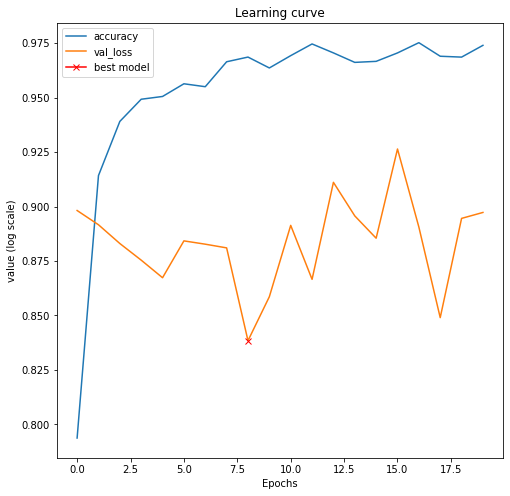

In [52]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["precision"], label="accuracy")
plt.plot(history.history["val_precision"], label="val_loss")
plt.plot( np.argmin(history.history["val_precision"]), np.min(history.history["val_precision"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

# Model prediction
In this part the trained model is used to predict the intestinal abnormalities present in the input image.

[[9.9999809e-01 3.0311594e-07 8.6233905e-07 6.7226699e-07]]
THE UPLOADED IMAGE SEEMS TO BE: Normal


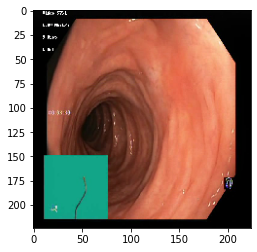

In [53]:
from keras.preprocessing import image
img = image.load_img('../input/curated-colon-dataset-for-deep-learning/test/0_normal/test_normal_ (1).jpg',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
    op="Normal"
elif a==1:
    op="Ulcerative colitis"
elif a==2:
    op="Polyp"
else:
    op="Esophagitis"  

plt.imshow(img)
print("THE UPLOADED IMAGE SEEMS TO BE: "+str(op))  


<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

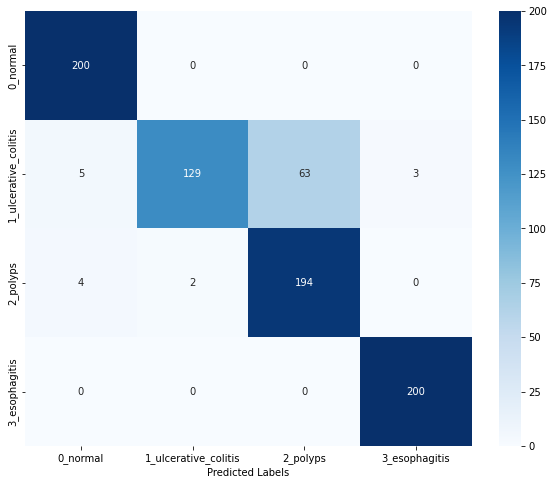

In [54]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Reset the test generator before predicting
test_generator.reset()

# Get the true labels and predicted probabilities from the model
true_labels = []
predicted_probs = []

# Iterate over the test data to get predictions
for i in range(len(test_generator)):
    imgs, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_probs.extend(np.argmax(model.predict(imgs), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_probs)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel


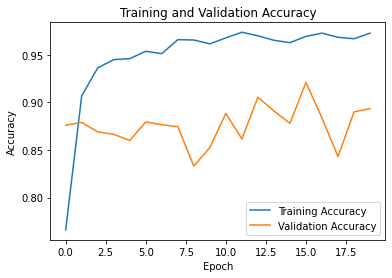

In [55]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


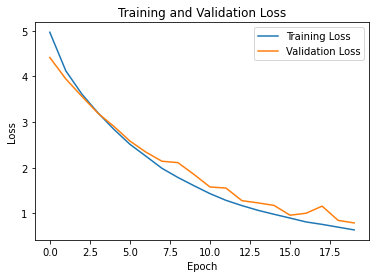

In [56]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
